# About

The purpose of this notebook is to generate the images used to demonstrate property calculations using coxeter.
Plots are rendered using matplotlib, and shapes are rendered using fresnel.

In [4]:
import coxeter
import fresnel
from matplotlib import pyplot as plt, patches
import numpy as np
import PIL

from mpl_toolkits import mplot3d 
import rowan

In [345]:
# We need bold math symbols.
plt.rcParams['text.latex.preamble'] = r"\usepackage{amsmath}"

In [5]:
%matplotlib widget

## Check points inside shape

Make a plot of checking if points are in shape.

In [400]:
vertices = np.array([
    [5, 0],
    [4, 4],
    [2, 2],
    [0, 5],
    [-1, 3],
    [-3, 4],
    [-5, 0],
    [-3, -4],
    [-1, -2],
    [2, -5],
]) / 5

polygon = coxeter.shapes.Polygon(vertices)

np.random.seed(38023)
test_points = np.random.rand(40, 3) * 2 - 1
test_points[:, 2] = 0

is_inside = polygon.is_inside(test_points)

fig, ax = plt.subplots(figsize=(6, 6))
polygon_plot = ax.add_patch(patches.Polygon(vertices[:, :2], fill=False, linewidth=7, edgecolor='k'))
ax.scatter(test_points[is_inside][:, 0], test_points[is_inside][:, 1], c='blue', s=300)
ax.scatter(test_points[~is_inside][:, 0], test_points[~is_inside][:, 1], c='red', s=300)

ax.tick_params(which='both', axis='both', labelsize=24,
               bottom=True, top=True, left=True, right=True,
               labelbottom=False, labeltop=False, labelleft=False, labelright=False,
              )
for spine in ax.spines.values():
    spine.set_linewidth(5)
fig.tight_layout()
ax.patch.set_alpha(0.5)
fig.patch.set_alpha(0)
fig.savefig('is_inside.png', transparent=True)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## Plot distance to surface.

Plot the insphere of a shape.

In [11]:
ngon = coxeter.families.RegularNGonFamily.get_shape(5)

# Random angles generated once for consistent plotting.
random_angles = np.array([2.62022653e+00, 4.52593227e+00, 7.18638172e-04])
distances = ngon.distance_to_surface(random_angles)
vectors = np.vstack((np.cos(random_angles), np.sin(random_angles))).T * distances[:, np.newaxis]

In [409]:
fig, ax = plt.subplots(figsize=(4, 4))
polygon_plot = ax.add_patch(patches.Polygon(ngon.vertices[:, :2], fill=False, linewidth=2, edgecolor='k'))
vectors_plot = [
    ax.add_patch(patches.FancyArrow(x=ngon.center[0], y=ngon.center[1], dx=v[0], dy=v[1],
                                    width=0.01, color='k', length_includes_head=True))
    for v in vectors
]
labels_plot = [
    ax.text(x=(ngon.center[0] + v[0]) / 2 + (0.02 if v[0] < 0 else -0.25),
            y=(ngon.center[1] + v[1]) / 2 + (0.05 if v[1] > 0 else -0.03),
            s=f"{distances[i]:1.3f}", fontsize=24, fontdict={'fontweight': 'bold'})
    for i, v in enumerate(vectors)
]

l0_pos = np.asarray(labels_plot[0].get_position())
l0_pos[0] -= 0.05
#labels_plot[0].set_position(l0_pos)

# Axes will not be autoscaled by patches.
extent = ngon.circumcircle.radius
ax.set_xlim([-extent, extent])
ax.set_ylim([-extent, extent])
for _, spine in ax.spines.items():
    spine.set_visible(False)
ax.tick_params(which='both', axis='both',
               labelbottom=False, labeltop=False, labelleft=False, labelright=False,
               bottom=False, top=False, left=False, right=False,
              )
fig.savefig('distance_to_surface.png', transparent=True)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## Show inertia tensor

Show the inertia tensor of a shape.
We choose something that is obviously not symmetric to highlight the asymmetry in the tensor and illustrate diagonalization.

In [290]:
for shape_id, data in coxeter.families.DOI_SHAPE_REPOSITORIES['10.1126/science.1220869'][0].data.items():
    if data['short_name'] == 'J08':
        break

In [291]:
def plot_polyhedron(poly, ax, trisurf_kwargs=None, line_kwargs=None):
    """Plot a polyhedron a provided set of axes.
    
    Currently plato does not handle 3D axes well.
    """
    if trisurf_kwargs is None:
        trisurf_kwargs = {}
    if line_kwargs is None:
        line_kwargs = {}

    # Generate a triangulation for plot_trisurf.
    vertex_to_index = {tuple(v): i for i, v in enumerate(poly.vertices)}
    triangles = [
        [vertex_to_index[tuple(v)] for v in triangle]
        for triangle in poly._surface_triangulation()
    ]        
    
    verts = poly.vertices
    ax.plot_trisurf(verts[:, 0], verts[:, 1], verts[:, 2], triangles=triangles, **trisurf_kwargs)

    # Add lines manually because trisurf will outline all triangles, even coplanar
    # ones that are part of the same face.
    for face in poly.faces:
        verts = poly.vertices[face]
        verts = np.concatenate((verts, verts[[0]]))
        ax.plot(verts[:, 0], verts[:, 1], verts[:, 2], **line_kwargs)

In [424]:
# Set up formatting of the generated primitives.
trisurf_kwargs = {
    # Make the triangles partly transparent.
    'color': tuple([*plt.get_cmap('Dark2').colors[3], 0.3])
}
line_kwargs = {
    'c': 'k',
    'lw': 0.4,
}

fig, ax = plt.subplots(figsize=(12, 12), subplot_kw={'projection': '3d'})

# Generate the polyhedron.
verts = rowan.rotate(
    [-0.6052796 ,  0.49886219, -0.21305172,  0.58256509],
    coxeter.families.DOI_SHAPE_REPOSITORIES['10.1126/science.1220869'][0].data[shape_id]['vertices']
)
pyramid = coxeter.shapes.ConvexPolyhedron(verts)
original_center = np.array([0, 0, 0])
pyramid.center = original_center
original_tensor = pyramid.inertia_tensor

plot_polyhedron(pyramid, ax, trisurf_kwargs, line_kwargs)

# Compute the inertia tensor in the COM frame.
pyramid.diagonalize_inertia()
diagonalized_tensor = pyramid.inertia_tensor

# Avoid rendering -0.
diagonalized_tensor_print = np.round(diagonalized_tensor, 2)
diagonalized_tensor_print[diagonalized_tensor_print == 0] = 0

shifted_center  = np.array([3, 0, 0])
pyramid.center = shifted_center
plot_polyhedron(pyramid, ax, trisurf_kwargs, line_kwargs)

# Plot the inertia tensors.
centers = np.vstack((np.repeat(original_center[np.newaxis, :], axis=0, repeats=3),
                     np.repeat(shifted_center[np.newaxis, :], axis=0, repeats=3)))

arrows = np.vstack((original_tensor, diagonalized_tensor)) * 3
ax.quiver3D(centers[:, 0], centers[:, 1], centers[:, 2],
            arrows[:, 0], arrows[:, 1], arrows[:, 2], color='k')


def matrix_to_latex_array(mat, num_digits=2):
    """Convert a 2D numpy array to a valid LaTeX string for an array."""
    mat = np.round(mat, num_digits)
    # Avoid -0 being rendered.
    mat[mat == 0] = 0
    matrix_contents = r' \\ '.join([
        r' & '.join([r"\boldsymbol{{{}}}".format(num) for num in row])
        for row in mat
    ])
    
    return r"$\left(\begin{array}{ccc} " + matrix_contents + r" \end{array}\right)$"
    

# Add the original tensor. 
ax.text(original_center[0] - 1, original_center[1], original_center[2] + 2,
        matrix_to_latex_array(original_tensor),
        fontdict={'usetex': True, 'fontsize': 24},
       )

# Add the diagonalized tensor. 
ax.text(shifted_center[0] - 0.8, shifted_center[1], shifted_center[2] + 2,
        matrix_to_latex_array(diagonalized_tensor),
        fontdict={'usetex': True, 'fontsize': 24},
       )


# Format the plot.
ax.view_init(elev=30, azim=-90)
limits = np.array([ax.get_xlim3d(), ax.get_ylim3d(), ax.get_zlim3d()])
center = np.mean(limits, axis=1)
radius = 0.5 * np.max(limits[:, 1] - limits[:, 0])
ax.set_xlim([center[0] - radius, center[0] + radius])
ax.set_ylim([center[1] - radius, center[1] + radius])
ax.set_zlim([center[2] - radius, center[2] + radius])
fig.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
fig.tight_layout()
ax.set_axis_off()
fig.savefig('inertia.png', transparent=True, bbox_inches='tight')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## Plot inspheres

Plot the insphere of a shape.

In [236]:
# Define a standard transparent material.
transparent_material = fresnel.material.Material(
    # Make the outside white and mostly transparent.
    color=fresnel.color.linear([1, 1, 1]),
    spec_trans=0.95,
    roughness=0.2,
    # Color is entirely determined by this material,
    # ignore the primitive.
    primitive_color_mix=0.0
)


# Define colors for shapes.
cmap = plt.get_cmap('jet')
color_values = [
    0.5160103820015511,
    0.6197072299697457,
    0.7999203755743276,
    0.3320403798697111,
    0.4166338123784348
]
colors = [cmap(x) for x in color_values]
colored_materials = {
    shape_name: fresnel.material.Material(
        color=fresnel.color.linear(colors[i]),
        roughness=0.8,
    )
    for i, shape_name in enumerate(coxeter.families.PlatonicFamily.data)
}

In [287]:
device = fresnel.Device()
scene = fresnel.Scene(device)

# Seed the random number generator for selecting colors.
np.random.seed(24)
cmap = plt.get_cmap('jet')

for i, shape_name in enumerate(coxeter.families.PlatonicFamily.data):
    # Get shape and insphere from coxeter.
    shape = coxeter.families.PlatonicFamily.get_shape(shape_name)
    # This normalization gives the best visual results for inspheres.
    shape.circumsphere_radius = 1
    insphere = shape.insphere
    
    # First make the shape and set up its properties.
    primitive = fresnel.geometry.ConvexPolyhedron(
        scene,
        fresnel.util.convex_polyhedron_from_vertices(shape.vertices),
        N=1,
        outline_width=0.01,
        material=transparent_material
    )
    primitive.color_by_face = 0.0

    primitive.position[:] = [[2.5 * i, 0, 0]]
    # Orientations chosen to give a reasonable view of the shape.
    if shape_name == 'Tetrahedron':
        primitive.orientation[:] = [0.39793087, 0.09596031, 0.82994888, 0.37898219]
    else:
        primitive.orientation[:] = [0.54916838, -0.20295039, -0.5506242 ,  0.59501111]

    # Now draw the insphere within the shape.
    sphere = fresnel.geometry.Sphere(scene, N=1)
    sphere.material = colored_materials[shape_name]

    sphere.position[:] = [[2.5 * i, 0, 0]]
    # Make the sphere a little bit smaller than it really is,
    # otherwise you get artifacts near the intersection of the
    # polyhedron and the insphere.
    sphere.radius[:] = [insphere.radius * 0.99]

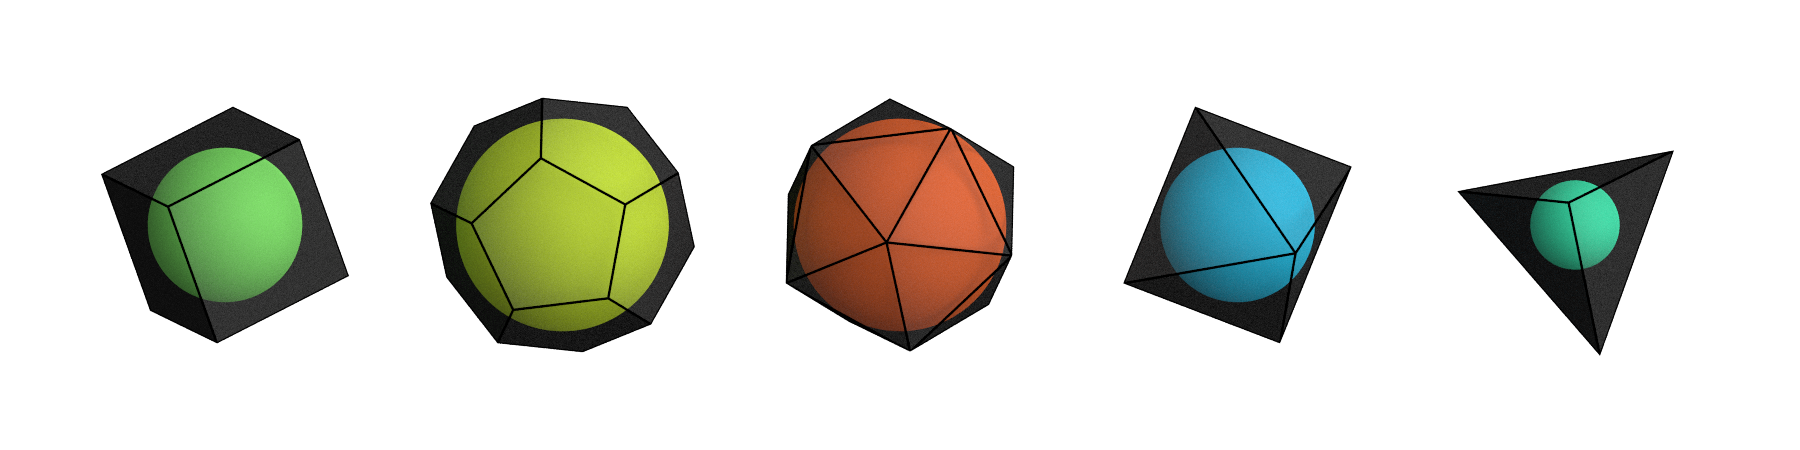

In [288]:
scene.camera = fresnel.camera.fit(scene, view='front', margin=4)
scene.camera.height /= 3
tracer = fresnel.tracer.Path(device=device, w=1800, h=450)
out = tracer.sample(scene, samples=64, light_samples=40)
out

In [289]:
image = PIL.Image.fromarray(out[:], mode='RGBA')
image.save('inspheres.png')

## Plot circumspheres

Plot the circumsphere of a shape.

In [280]:
device = fresnel.Device()
scene = fresnel.Scene(device)

# Seed the random number generator for selecting colors.
np.random.seed(24)
cmap = plt.get_cmap('jet')

for i, shape_name in enumerate(coxeter.families.PlatonicFamily.data):
    shape = coxeter.families.PlatonicFamily.get_shape(shape_name)
    # This normalization gives the best visual results for inspheres.
    shape.circumsphere_radius = 1
    circumsphere = shape.circumsphere
    
    # First make the shape and set up its properties.
    poly_info = fresnel.util.convex_polyhedron_from_vertices(shape.vertices)
    for j in range(len(poly_info['face_sides'])):
        poly_info['face_color'][j] = fresnel.color.linear([0, 0, 0])
    primitive = fresnel.geometry.ConvexPolyhedron(
        scene,
        poly_info,
        N=1,
        outline_width=0.01,
        material=colored_materials[shape_name]
    )
    primitive.color_by_face = 0.0
    
    primitive.position[:] = [[2.5 * i, 0, 0]]
    # Orientations chosen to give a reasonable view of the shape.
    if shape_name == 'Tetrahedron':
        primitive.orientation[:] = [0.39793087, 0.09596031, 0.82994888, 0.37898219]
    else:
        primitive.orientation[:] = [0.54916838, -0.20295039, -0.5506242 ,  0.59501111]

    # Now draw the circumsphere within the shape.
    sphere = fresnel.geometry.Sphere(scene, N=1)
    sphere.material = transparent_material

    sphere.position[:] = [[2.5 * i, 0, 0]]
    # Make the sphere a little bit bigger than it really is,
    # otherwise you get artifacts near the intersection of the
    # polyhedron and the circumsphere.
    sphere.radius[:] = [circumsphere.radius * 1.01]

In [283]:
scene.camera = fresnel.camera.fit(scene, view='front', margin=4)
scene.camera.height /= 3

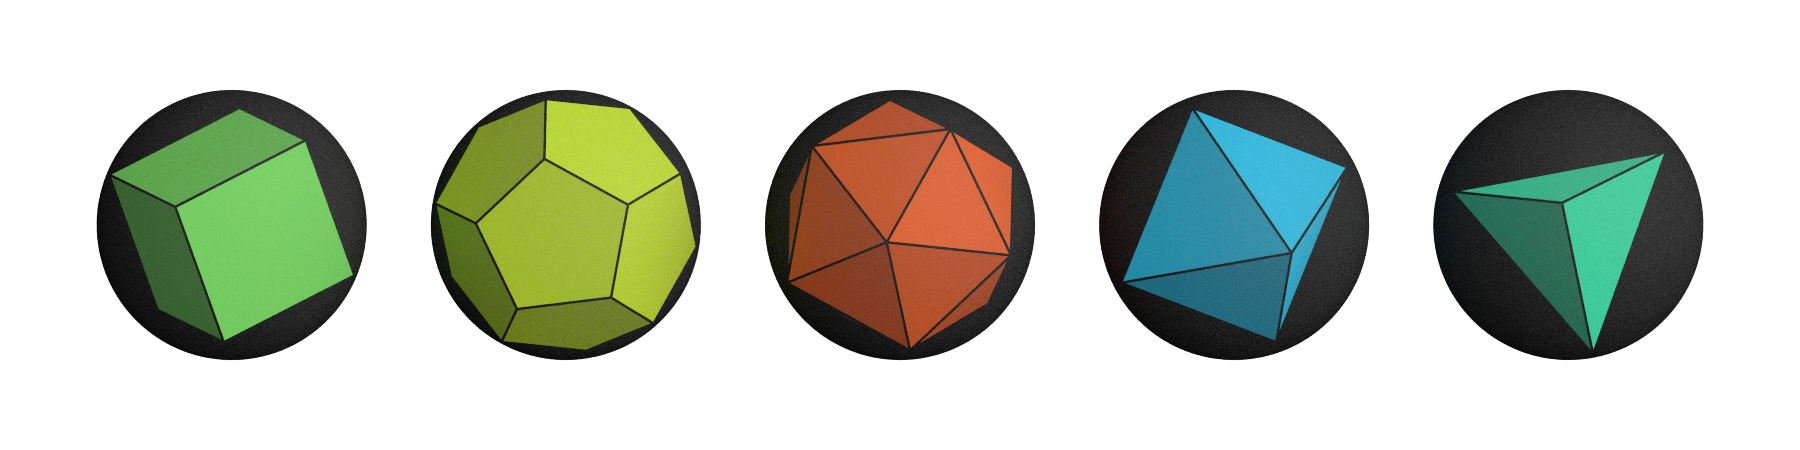

In [284]:
tracer = fresnel.tracer.Path(device=device, w=1800, h=450)
out = tracer.sample(scene, samples=64, light_samples=40)
out

In [285]:
image = PIL.Image.fromarray(out[:], mode='RGBA')
image.save('circumspheres.png')

## Calculate form factors

Plot the circumsphere of a shape.

In [27]:
R = 1
sphere = coxeter.shapes.Sphere(R)
tetrahedron = coxeter.families.PlatonicFamily.get_shape('Tetrahedron')
tetrahedron.insphere_radius = sphere.radius

In [39]:
# The form factor amplitude is designed to account for
# shifting the particle position, so to simplify we just
# compute for all 1D vectors shifting along x.
q = np.linspace(0.0001, 20, 100)
rho = 0.0005
qR = q * R

q_vectors_x = np.zeros((q.shape[0], 3))
q_vectors_y = np.zeros((q.shape[0], 3))
q_vectors_z = np.zeros((q.shape[0], 3))
q_vectors_x[:, 0] = q
q_vectors_y[:, 1] = q
q_vectors_z[:, 2] = q
F_sphere = sphere.compute_form_factor_amplitude(q_vectors_x, density=rho)
F_tet_x = tetrahedron.compute_form_factor_amplitude(q_vectors_x, density=rho)
F_tet_y = tetrahedron.compute_form_factor_amplitude(q_vectors_y, density=rho)
F_tet_z = tetrahedron.compute_form_factor_amplitude(q_vectors_z, density=rho)

In [423]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.semilogy(qR, (F_sphere.real) ** 2, label='Sphere', lw=4, ls='dotted')

# The form factors intensities of the tetrahedron would
# require a surface integral, since we're just interesting
# in showing something to get the point across it's easier
# to just rescale the amplitude and square it.
# I tried showing three, but it's too crowded to see.
scale_factor = F_sphere[0].real / F_tet_x[0].real
ax.semilogy(qR, (scale_factor * F_tet_x.real) ** 2 * 4 * np.pi, label='Tetrahedron $x$')
ax.semilogy(qR, (scale_factor * F_tet_z.real) ** 2 * 4 * np.pi, label='Tetrahedron $z$')
#ax.semilogy(qR, (scale_factor * F_tet_z.real) ** 2 * 4 * np.pi, label='Tetrahedron')

#ax.legend(fontsize=28, loc='best')
ax.set_xlabel(r'$\boldsymbol{qR}$', fontsize=48, usetex=True)
ax.set_ylabel(r'$\boldsymbol{F^2(qR)}$', fontsize=48, usetex=True)
ax.tick_params(which='both', axis='both', labelsize=0)
fig.tight_layout()
ax.patch.set_alpha(0.5)
fig.patch.set_alpha(0)
fig.savefig('form_factor.png')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …